```Performance Comparsion with various model in Sequence Length 256```
- Model Size: 0.9M

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import numpy as np
import time
import matplotlib.pyplot as plt
import pandas as pd

## Hyperparameters and Configuration

In [2]:
# Modified hyperparameters
SEQUENCE_LENGTH = 256

EMBEDDING_DIM = SEQUENCE_LENGTH
HIDDEN_DIM = EMBEDDING_DIM

BATCH_SIZE = 1024
EPOCHS = 20
LEARNING_RATE = 1e-4
VALIDATION_SPLIT = 0.1

NUM_LAYERS = 2
NUM_HEADS = 4
FFN_DIM = SEQUENCE_LENGTH
DROPOUT = 0.1

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

Using device: cuda:0


## Data Preparation

We are using the TinyShakespeare dataset, a small character-level text corpus consisting of a subset of Shakespeare's plays. It's often used for testing sequence models, as it includes a rich set of vocabulary and provides a challenging task for next-character prediction.

In [3]:
## Utility Functions

def load_data(filename):
    with open(filename, 'r', encoding='utf-8') as f:
        return f.read()

def create_char_mappings(text):
    chars = sorted(list(set(text)))
    char_to_idx = {ch: i for i, ch in enumerate(chars)}
    idx_to_char = {i: ch for i, ch in enumerate(chars)}
    return chars, char_to_idx, idx_to_char

## Dataset

In [4]:
class CharDataset(Dataset):
    def __init__(self, text, seq_length, char_to_idx):
        self.text = text
        self.seq_length = seq_length
        self.char_to_idx = char_to_idx

    def __len__(self):
        return len(self.text) - self.seq_length

    def __getitem__(self, idx):
        x = [self.char_to_idx[ch] for ch in self.text[idx:idx+self.seq_length]]
        y = [self.char_to_idx[ch] for ch in self.text[idx+1:idx+self.seq_length+1]]
        return torch.tensor(x), torch.tensor(y)

In [5]:
def prepare_data(text, seq_length, batch_size, val_split):
    chars, char_to_idx, idx_to_char = create_char_mappings(text)

    # Split data into train and validation
    val_size = int(len(text) * val_split)
    train_text, val_text = text[:-val_size], text[-val_size:]

    train_dataset = CharDataset(train_text, seq_length, char_to_idx)
    val_dataset = CharDataset(val_text, seq_length, char_to_idx)

    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=12, pin_memory=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=12, pin_memory=True)

    return train_loader, val_loader, chars, char_to_idx, idx_to_char

In [6]:
# !wget --no-check-certificate 'https://drive.google.com/uc?export=download&id=19zosLuU0z4MxIMKbGVYEGlg52QyfbTIy' -O input.txt

In [7]:
# Load the data
text = load_data('../data/input.txt')
train_loader, val_loader, chars, char_to_idx, idx_to_char = prepare_data(text, SEQUENCE_LENGTH, BATCH_SIZE, VALIDATION_SPLIT)
vocab_size = len(chars)

print(f"Total characters: {len(text)}")
print(f"Vocabulary size: {vocab_size}")
print(f"Train dataset size: {len(train_loader.dataset)}")
print(f"Validation dataset size: {len(val_loader.dataset)}")

Total characters: 1115394
Vocabulary size: 65
Train dataset size: 1003599
Validation dataset size: 111283


## Data Visualization

In [8]:
# Function to convert index sequence to character sequence
def indices_to_text(indices, idx_to_char):
    return ''.join([idx_to_char[idx.item()] for idx in indices])

# Get a batch of data
dataiter = iter(train_loader)
batch_x, batch_y = next(dataiter)

print(f"Input shape: {batch_x.shape}")
print(f"Target shape: {batch_y.shape}")

# Print a few samples from the batch
num_samples = 3
for i in range(num_samples):
    print(f"Sample {i+1}: ------------------------------" )
    print("Input sequence :", indices_to_text(batch_x[i], idx_to_char).replace('\n',''))
    print("Target sequence:", indices_to_text(batch_y[i], idx_to_char).replace('\n',''))
    print()


Input shape: torch.Size([1024, 256])
Target shape: torch.Size([1024, 256])
Sample 1: ------------------------------
Input sequence : ium.CORIOLANUS:I wish I had a cause to seek him there,To oppose his hatred fully. Welcome home.Behold, these are the tribunes of the people,The tongues o' the common mouth: I do despise them;For they do prank them in authority,Against all noble suf
Target sequence: um.CORIOLANUS:I wish I had a cause to seek him there,To oppose his hatred fully. Welcome home.Behold, these are the tribunes of the people,The tongues o' the common mouth: I do despise them;For they do prank them in authority,Against all noble suff

Sample 2: ------------------------------
Input sequence : I have stood by, my lord, and I have heardYour royal ear abused. First, hath this womanMost wrongfully accused your substitute,Who is as free from touch or soil with herAs she from one ungot.DUKE VINCENTIO:We did believe no less.Know you that Fria
Target sequence: I have stood by, my lord, an

## Training Function

In [9]:
def print_vram_usage(device="cuda"):
    allocated = torch.cuda.memory_allocated(device) / (1024**2)  # in MB
    reserved = torch.cuda.memory_reserved(device) / (1024**2)    # in MB
    max_allocated = torch.cuda.max_memory_allocated(device) / (1024**2)  # in MB
    print(f"Allocated: {allocated:.2f} MB, Reserved: {reserved:.2f} MB, Max Allocated: {max_allocated:.2f} MB")

In [10]:
def validate(model, dataloader, criterion, device, epoch, step):
    model.eval()
    losses = []
    with torch.no_grad():
        for x, y in dataloader:
            x, y = x.to(device), y.to(device)
            output, _ = model(x)
            loss = criterion(output.view(-1, output.size(-1)), y.view(-1))
            losses.append((step, epoch, loss.item()))
    return losses

In [11]:
from tqdm import tqdm

def train(model, dataloader, criterion, optimizer, device, epoch, step):
    model.train()
    losses = []
    vram_usage = []
    scaler = torch.amp.GradScaler('cuda')
    pbar = tqdm(dataloader, desc=f"Epoch {epoch}", leave=False)
    for batch, (x, y) in enumerate(pbar):
        x, y = x.to(device), y.to(device)
        optimizer.zero_grad()
        
        with torch.amp.autocast('cuda'):
            output, _ = model(x)
            loss = criterion(output.view(-1, output.size(-1)), y.view(-1))
            
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()

        step += 1
        losses.append((step, epoch, loss.item()))
        
        # VRAM 사용량을 progress bar의 postfix로 업데이트
        allocated = torch.cuda.memory_allocated(device) / (1024**2)
        vram_usage.append(allocated)
        pbar.set_postfix(loss=f'{loss.item():.4f}', step=step, vram=f'{allocated:.2f} MB')
    return losses, step, vram_usage

## Generation Function

In [12]:
def train_model(model, train_loader, val_loader, criterion, optimizer, device, epochs):
    all_train_losses = []
    all_val_losses = []
    all_vram_usages = []
    step = 0

    for epoch in range(1, epochs + 1):
        epoch_start_time = time.time()
        # Training phase with tqdm updates
        epoch_train_losses, step, vram_usage = train(model, train_loader, criterion, optimizer, device, epoch, step)
        all_train_losses.extend(epoch_train_losses)
        all_vram_usages.append(vram_usage)
        
        # Validation phase
        epoch_val_losses = validate(model, val_loader, criterion, device, epoch, step)
        all_val_losses.extend(epoch_val_losses)
        
        epoch_time = time.time() - epoch_start_time
        print(f'Epoch {epoch}/{epochs}, Train Loss: {epoch_train_losses[-1][2]:.4f}, '
              f'Val Loss: {epoch_val_losses[-1][2]:.4f}, Epoch Time: {epoch_time:.2f}s',
              f'Average Vram Usage: {np.mean(vram_usage):.2f}MB')

    train_losses_df = pd.DataFrame(all_train_losses, columns=['step', 'epoch', 'loss_value'])
    val_losses_df = pd.DataFrame(all_val_losses, columns=['step', 'epoch', 'loss_value'])
    # average_vram_usage = np.mean(all_vram_usages)
    return model, train_losses_df, val_losses_df


In [13]:
def generate_text(model, char_to_idx, idx_to_char, start_text, device, max_length=500):
    model.eval()
    current_text = start_text
    hidden = None

    with torch.no_grad():
        for _ in range(max_length):
            x = torch.tensor([[char_to_idx[ch] for ch in current_text[-SEQUENCE_LENGTH:]]]).to(device)
            output, hidden = model(x, hidden)
            probs = torch.softmax(output[0, -1], dim=0)
            next_char_idx = torch.multinomial(probs, 1).item()
            next_char = idx_to_char[next_char_idx]
            current_text += next_char

    return current_text

In [14]:
loss_comparison_dict = {}

def add_loss_to_comparison(model_name, train_losses_df, val_losses_df):
    """
    Adds training and validation losses from a model to the comparison dictionary.
    """
    loss_comparison_dict[model_name] = {
        'train': train_losses_df,
        'val': val_losses_df
    }

def print_final_losses(loss_dict):
    for model_name, losses in loss_dict.items():
        train_df = losses['train']
        val_df = losses['val']
        final_train = train_df.groupby('epoch')['loss_value'].last().iloc[-1]
        final_val = val_df.groupby('epoch')['loss_value'].last().iloc[-1]
        print(f"{model_name}: Final Train Loss: {final_train:.4f}, Final Val Loss: {final_val:.4f}")

In [15]:
# Function to plot loss curves
def plot_loss(train_losses_df, val_losses_df):
    plt.figure(figsize=(10, 5))

    # Plot training losses
    for epoch in train_losses_df['epoch'].unique():
        epoch_train_losses = train_losses_df[train_losses_df['epoch'] == epoch]
        plt.plot(epoch_train_losses['step'], epoch_train_losses['loss_value'],
                 color='blue', alpha=0.3)

    # scatter training loss at the end of each epoch
    last_train_losses = train_losses_df.groupby('epoch').last().reset_index()
    plt.scatter(last_train_losses['step'], last_train_losses['loss_value'],
                color='blue')

    # Plot and scatter validation loss at the end of each epoch
    last_val_losses = val_losses_df.groupby('epoch').last().reset_index()
    plt.plot(last_val_losses['step'], last_val_losses['loss_value'],
             color='orange', label='Validation Loss')
    plt.scatter(last_val_losses['step'], last_val_losses['loss_value'],
                color='orange')

    plt.xlabel('Steps')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss')
    plt.legend()
    plt.grid(True)
    plt.show()

# Function to print final loss values
def print_final_losses(train_losses_df, val_losses_df):
    print("Final Training Loss:", train_losses_df.groupby('epoch')['loss_value'].last().iloc[-1])
    print("Final Validation Loss:", val_losses_df.groupby('epoch')['loss_value'].last().iloc[-1])

In [16]:
# Function to plot loss curves for multiple models stored in loss_comparison_dict
def plot_loss_comparisons():
    """
    Plots the training loss curves and average validation loss per epoch for multiple models added to the loss comparison dictionary.
    """
    plt.figure(figsize=(10, 5))
    
    # Get the last model in the dictionary (for special final-point highlighting)
    last_model_name = list(loss_comparison_dict.keys())[-1]

    # Loop through each model in the loss dictionary
    for model_name, losses in loss_comparison_dict.items():
        train_losses_df = losses['train']
        val_losses_df = losses['val']

        # Plot training losses for each model
        plt.plot(train_losses_df['step'], train_losses_df['loss_value'],
                 label=f'{model_name} train', linestyle='-', alpha=0.7)

        # Scatter training loss at the end of each epoch
        last_train_losses = train_losses_df.groupby('epoch').last().reset_index()
        plt.scatter(last_train_losses['step'], last_train_losses['loss_value'], marker='o', s=50)

        # Compute average validation loss per epoch (using the last step of each epoch for x-axis)
        avg_val_losses = val_losses_df.groupby('epoch').agg({'loss_value': 'mean', 'step': 'last'}).reset_index()
        # Scatter the average validation loss for each epoch
        plt.scatter(avg_val_losses['step'], avg_val_losses['loss_value'], marker='s', s=50,
                    label=f'{model_name} val avg')

        # For the last model, highlight the final training loss with a star
        if model_name == last_model_name:
            final_step = train_losses_df['step'].iloc[-1]
            final_loss = train_losses_df['loss_value'].iloc[-1]
            plt.scatter(final_step, final_loss, marker='*', s=100, color='red', zorder=5)

    plt.xlabel('Steps')
    plt.ylabel('Loss')
    plt.title('Training Loss Comparison')
    plt.legend()  # Legend shows both training and validation average labels
    plt.grid(True)
    plt.show()


In [17]:
def plot_separate_train_val(loss_dict):
    """
    모델별 Training Loss와 Validation Loss를 각각 별도의 그래프로 그립니다.
    단, Validation Loss는 에포크별 평균으로 계산합니다.
    """
    # 1. Training Loss Plot (원본 그대로)
    plt.figure(figsize=(20, 5))
    plt.subplot(1, 2, 1)  # 1행 2열 중 첫 번째
    for model_name, losses in loss_dict.items():
        train_df = losses['train']
        steps_train = train_df['step'].values
        loss_train = train_df['loss_value'].values
        plt.plot(steps_train, loss_train, label=f'{model_name} Train')
    plt.title('Training Loss Comparison')
    plt.xlabel('Steps')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)

    # 2. Validation Loss Plot (에포크별 평균 처리)
    plt.subplot(1, 2, 2)  # 1행 2열 중 두 번째
    for model_name, losses in loss_dict.items():
        val_df = losses['val']
        # 에포크별 평균 loss와 마지막 step을 계산
        val_avg = val_df.groupby('epoch').agg({'loss_value': 'mean', 'step': 'last'}).reset_index()
        plt.plot(val_avg['step'], val_avg['loss_value'], label=f'{model_name} Val')
    plt.title('Validation Loss (Epoch Avg) Comparison')
    plt.xlabel('Steps')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)

    plt.tight_layout()
    plt.show()


## Model 1: GRU Decoder

In [18]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class GRUDecoder(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, num_layers=2, dropout=0.1):
        super(GRUDecoder, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.gru = nn.GRU(embedding_dim, hidden_dim, num_layers=num_layers,
                          dropout=dropout if num_layers > 1 else 0.0, batch_first=True)
        self.fc1 = nn.Linear(hidden_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, vocab_size)
        self.dropout = nn.Dropout(dropout)
        self.layer_norm = nn.LayerNorm(hidden_dim)

    def forward(self, x, hidden=None):
        embed = self.embedding(x)
        output, hidden = self.gru(embed, hidden)
        output = self.dropout(output)
        output = self.layer_norm(output)
        output = F.gelu(self.fc1(output))
        output = self.fc2(output)
        return output, hidden

In [19]:
### Model Initialization
gru = GRUDecoder(vocab_size, EMBEDDING_DIM, HIDDEN_DIM, NUM_LAYERS).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(gru.parameters(), lr=LEARNING_RATE, fused=True)

In [20]:
from torchinfo import summary

summary(gru, input_size=(BATCH_SIZE, SEQUENCE_LENGTH), dtypes=[torch.long])

Layer (type:depth-idx)                   Output Shape              Param #
GRUDecoder                               [1024, 256, 65]           --
├─Embedding: 1-1                         [1024, 256, 256]          16,640
├─GRU: 1-2                               [1024, 256, 256]          789,504
├─Dropout: 1-3                           [1024, 256, 256]          --
├─LayerNorm: 1-4                         [1024, 256, 256]          512
├─Linear: 1-5                            [1024, 256, 256]          65,792
├─Linear: 1-6                            [1024, 256, 65]           16,705
Total params: 889,153
Trainable params: 889,153
Non-trainable params: 0
Total mult-adds (G): 207.07
Input size (MB): 2.10
Forward/backward pass size (MB): 2283.80
Params size (MB): 3.56
Estimated Total Size (MB): 2289.45

In [21]:
## Training Loop
trained_model, train_losses_df, val_losses_df = train_model(gru, train_loader, val_loader, criterion, optimizer, device, EPOCHS)

Epoch 1/20, Train Loss: 1.5626, Val Loss: 1.7008, Epoch Time: 52.54s Average Vram Usage: 72.35MB


Epoch 2/20, Train Loss: 1.3763, Val Loss: 1.6352, Epoch Time: 52.30s Average Vram Usage: 72.35MB


Epoch 3/20, Train Loss: 1.2923, Val Loss: 1.6288, Epoch Time: 52.39s Average Vram Usage: 72.35MB


Epoch 4/20, Train Loss: 1.2169, Val Loss: 1.6325, Epoch Time: 52.33s Average Vram Usage: 72.35MB


Epoch 5/20, Train Loss: 1.1827, Val Loss: 1.6396, Epoch Time: 52.10s Average Vram Usage: 72.35MB


Epoch 6/20, Train Loss: 1.1397, Val Loss: 1.6595, Epoch Time: 52.30s Average Vram Usage: 72.35MB


Epoch 7/20, Train Loss: 1.1157, Val Loss: 1.6777, Epoch Time: 52.20s Average Vram Usage: 72.35MB


Epoch 8/20, Train Loss: 1.0889, Val Loss: 1.7111, Epoch Time: 52.38s Average Vram Usage: 72.35MB


Epoch 9/20, Train Loss: 1.0515, Val Loss: 1.7546, Epoch Time: 52.35s Average Vram Usage: 72.35MB


Epoch 10/20, Train Loss: 1.0285, Val Loss: 1.8129, Epoch Time: 52.36s Average Vram Usage: 72.35MB


Epoch 11/20, Train Loss: 1.0047, Val Loss: 1.8551, Epoch Time: 52.46s Average Vram Usage: 72.35MB


Epoch 12/20, Train Loss: 0.9989, Val Loss: 1.8953, Epoch Time: 52.17s Average Vram Usage: 72.35MB


Epoch 13/20, Train Loss: 0.9698, Val Loss: 1.9326, Epoch Time: 52.42s Average Vram Usage: 72.35MB


Epoch 14/20, Train Loss: 0.9700, Val Loss: 1.9823, Epoch Time: 52.79s Average Vram Usage: 72.35MB


Epoch 15/20, Train Loss: 0.9481, Val Loss: 2.0161, Epoch Time: 52.30s Average Vram Usage: 72.35MB


Epoch 16/20, Train Loss: 0.9224, Val Loss: 2.0496, Epoch Time: 52.04s Average Vram Usage: 72.35MB


Epoch 17/20, Train Loss: 0.8994, Val Loss: 2.0996, Epoch Time: 52.03s Average Vram Usage: 72.35MB


Epoch 18/20, Train Loss: 0.9318, Val Loss: 2.1276, Epoch Time: 51.82s Average Vram Usage: 72.35MB


Epoch 19/20, Train Loss: 0.8854, Val Loss: 2.1512, Epoch Time: 52.30s Average Vram Usage: 72.35MB


Epoch 20/20, Train Loss: 0.8843, Val Loss: 2.1812, Epoch Time: 51.97s Average Vram Usage: 72.35MB


In [22]:
# Text generation using validation data
val_sample, _ = next(iter(val_loader))
start_text = ''.join([idx_to_char[idx.item()] for idx in val_sample[0][:SEQUENCE_LENGTH]])

In [23]:
generated_text = generate_text(trained_model, char_to_idx, idx_to_char, start_text, device)
                      
print(f"Generated text (starting with validation data [{start_text}]):")
print("-"*50)
print(generated_text)

Generated text (starting with validation data [

GREMIO:
Good morrow, neighbour Baptista.

BAPTISTA:
Good morrow, neighbour Gremio.
God save you, gentlemen!

PETRUCHIO:
And you, good sir! Pray, have you not a daughter
Call'd Katharina, fair and virtuous?

BAPTISTA:
I have a daughter, sir, called Kathar]):
--------------------------------------------------


GREMIO:
Good morrow, neighbour Baptista.

BAPTISTA:
Good morrow, neighbour Gremio.
God save you, gentlemen!

PETRUCHIO:
And you, good sir! Pray, have you not a daughter
Call'd Katharina, fair and virtuous?

BAPTISTA:
I have a daughter, sir, called Kathar:
His night do your heart: not done a fool.

SICINIUS:
Ye sooner not hath denied there;
And, with his state, that dost thou speak me now!

KING RICHARD II:
Marry, thou mayst entreat the matter
That came in't our well-heartily keppress.

Holy OFERDI:
I do not know your honour, and I never
I will deserve to allow.

VIRGILIA:
What is the name?

Page:
Accept, his men should not have thee

In [24]:
# After training a model (e.g., LSTM without RMSNorm), add its losses
add_loss_to_comparison('GRU', train_losses_df, val_losses_df)

In [25]:
# Decoder Input/Output Example
sample_input, _ = next(iter(val_loader))
sample_input = sample_input[0].unsqueeze(0).to(device)  # Add batch dimension

trained_model.eval()
with torch.no_grad():
    output, _ = trained_model(sample_input)

print("\nSample Input:")
print(''.join([idx_to_char[idx.item()] for idx in sample_input[0]]))

print("\nModel Output (logits for next character prediction):")
print(output.shape)
print(output[0, 0, :10])  # Print first 10 logits of the first timestep

print("\nPredicted next character:")
predicted_char_idx = torch.argmax(output[0, -1]).item()
print(idx_to_char[predicted_char_idx])


Sample Input:


GREMIO:
Good morrow, neighbour Baptista.

BAPTISTA:
Good morrow, neighbour Gremio.
God save you, gentlemen!

PETRUCHIO:
And you, good sir! Pray, have you not a daughter
Call'd Katharina, fair and virtuous?

BAPTISTA:
I have a daughter, sir, called Kathar

Model Output (logits for next character prediction):
torch.Size([1, 256, 65])
tensor([  4.8363,  -7.1493, -13.4951,  -9.3933,  -9.3415,   0.7771, -15.0726,
         -7.4653,  -9.9421,  -3.9519], device='cuda:0')

Predicted next character:
i


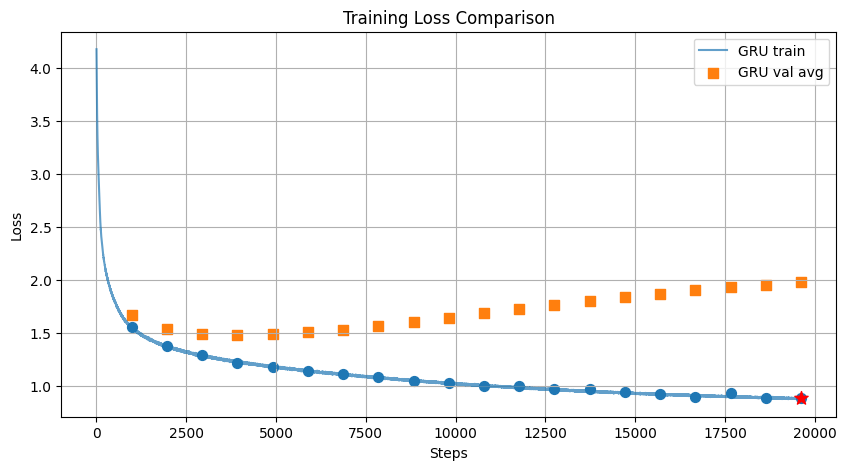

In [26]:
plot_loss_comparisons()

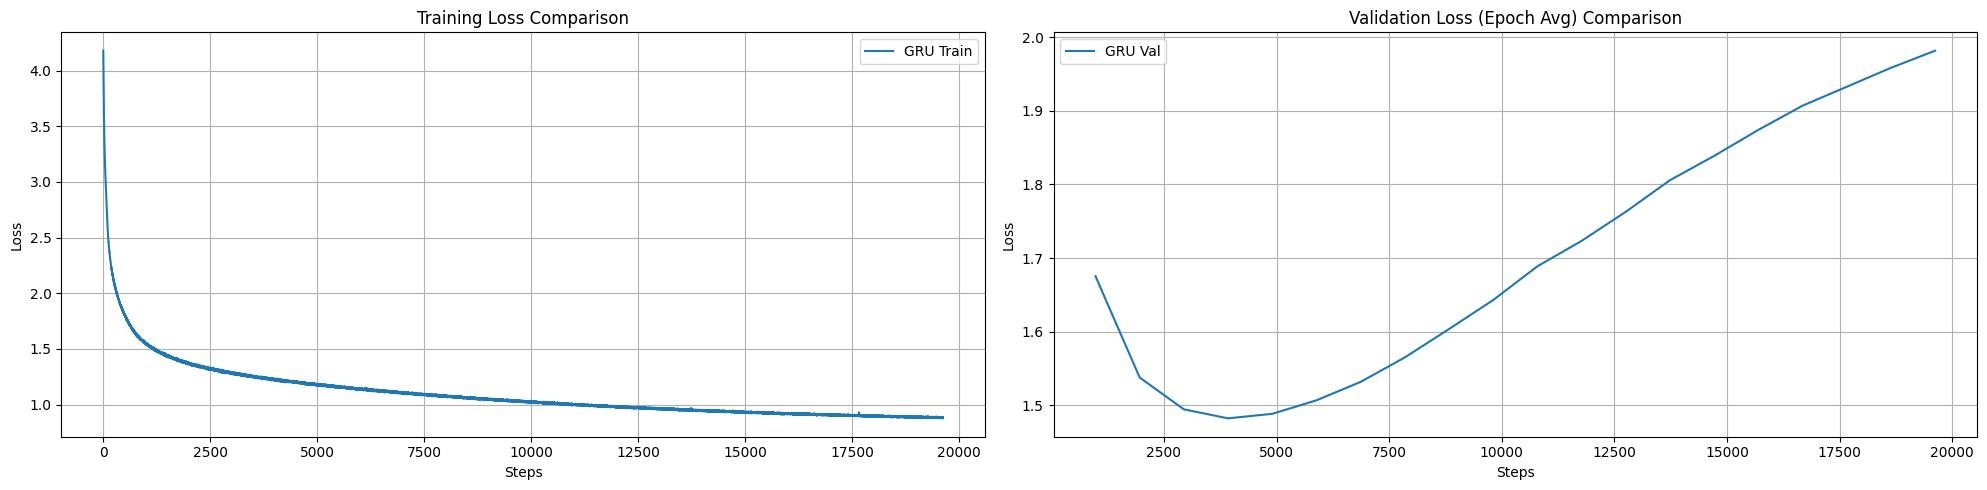

In [27]:
plot_separate_train_val(loss_comparison_dict)

In [28]:
def generate_text_attention(model, char_to_idx, idx_to_char, start_text, device, max_length=500):
    model.eval()
    current_text = start_text

    with torch.no_grad():
        for _ in range(max_length):
            # Convert the last sequence of characters to indices and feed it to the model
            x = torch.tensor([[char_to_idx[ch] for ch in current_text[-SEQUENCE_LENGTH:]]]).to(device)
            output = model(x)[0]  # No hidden state needed for attention-based models
            probs = torch.softmax(output[0, -1], dim=0)
            next_char_idx = torch.multinomial(probs, 1).item()
            next_char = idx_to_char[next_char_idx]
            current_text += next_char

    return current_text

In [29]:
def train_and_test(model_desc, model, start_text):
    # Initialize the model
    model = model.to(device)
    # Use the same optimizer and criterion
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.AdamW(model.parameters(), lr=LEARNING_RATE, fused=True)
    
    # Train the model
    trained_model, train_losses_df, val_losses_df = train_model(
        model, train_loader, val_loader, criterion, optimizer, device, EPOCHS
    )

    # Generate text
    generated_text = generate_text_attention(trained_model, char_to_idx, idx_to_char, start_text, device)
    print(f"Generated text [{start_text}]:")
    print("-"*50)
    print(generated_text)
    
    add_loss_to_comparison(model_desc, train_losses_df, val_losses_df)

    # Plot loss comparisons including this model
    plot_loss_comparisons()
    
    plot_separate_train_val(loss_comparison_dict)

## Model 2: Modern Transformer(LLaMA - 2023)

In [30]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import math
from dataclasses import dataclass

@dataclass
class ModelArgs:
    DIM = EMBEDDING_DIM 
    FFN_DIM = int(FFN_DIM*.9)
    NUM_HEADS = NUM_HEADS 
    NUM_LAYERS = NUM_LAYERS

    NUM_KV_HEADS = NUM_HEADS 
    VOCAB_SIZE = vocab_size
    NORM_EPS = 1e-5 # LLaMA: 1e-5
    ROPE_THETA = 10000 # LLaMA: 10000

    MAX_BATCH_SIZE = BATCH_SIZE
    MAX_SEQ_LEN = SEQUENCE_LENGTH # depending on the DATASET
    NUM_KV_HEAD_REP = NUM_HEADS // NUM_KV_HEADS

    HEAD_DIM = DIM // NUM_HEADS
    DROPOUT = DROPOUT
    DEVICE = device

class RMSNorm(nn.Module):
    def __init__(self, dim: int, eps: float = 1e-6):
        super().__init__()
        self.eps = eps
        self.weight = nn.Parameter(torch.ones(dim))
    def _norm(self, x: torch.Tensor):
        return x * torch.rsqrt(x.pow(2).mean(-1, keepdim=True) + self.eps)
    def forward(self, x: torch.Tensor):
        return self.weight.to(x.device) * self._norm(x.float()).type_as(x)
    
def precompute_freqs_cis(head_dim: int, seq_len: int, theta: float = 100.0, device: str = "cuda:0"):
    if head_dim % 2 != 0:
        raise ValueError("head_dim must be even for rotary embeddings.")
    freqs = 1.0 / (theta ** (torch.arange(0, head_dim, 2).float() / head_dim)).to(device)
    t = torch.arange(seq_len, device=device, dtype=torch.float32)
    freqs = torch.outer(t, freqs)  # [seq_len, head_dim//2]
    freqs_cis = torch.polar(torch.ones_like(freqs), freqs)
    return freqs_cis  # [seq_len, head_dim // 2]

def reshape_for_broadcast(freqs_cis: torch.Tensor, x: torch.Tensor):
    L = x.shape[1]
    return freqs_cis.view(1, L, 1, x.shape[-1] // 2)  # [1, L, 1, head_dim]

def apply_rotary_emb(x: torch.Tensor, device: str = "cuda:0"):
    # x: [B, L, 2*heads, D] & D is even
    _, L, _, D = x.shape
    x_complex = torch.view_as_complex(x.float().reshape(*x.shape[:-1], -1, 2)) # [B, L, 2*heads, D//2, 2]
    freqs_cis = precompute_freqs_cis(D, L)
    freqs = reshape_for_broadcast(freqs_cis, x)
    x_rotated = x_complex * freqs
    x_out = torch.view_as_real(x_rotated).reshape(x.shape)
    return x_out.type_as(x).to(device)

def repeat_kv(x: torch.Tensor, n_rep: int) -> torch.Tensor:
    B, L, nk, d = x.shape
    if n_rep == 1:
        return x
    return x[:, :, :, None, :].expand(B, L, nk, n_rep, d).reshape(B, L, nk * n_rep, d)

class FeedForward(nn.Module):
    def __init__(self, dim, ffn_dim, dropout):
        super().__init__()
        hidden_dim = ffn_dim
        self.w1 = nn.Linear(dim, hidden_dim, bias=False)
        self.w2 = nn.Linear(hidden_dim, dim, bias=False)
        self.w3 = nn.Linear(dim, hidden_dim, bias=False)
        self.dropout = nn.Dropout(dropout)
    def forward(self, x: torch.Tensor):
        # x: [B, L, D]
        return self.w2(F.silu(self.w1(x)) * self.dropout(self.w3(x)))

class SelfAttention(nn.Module):
    def __init__(self, n_heads, n_kv_heads, n_rep, dim, dropout, batch, seq_len, device):
        super().__init__()
        self.n_heads_q = n_heads
        self.n_kv_heads = n_kv_heads
        self.n_rep = n_rep
        self.head_dim = dim // n_heads

        self.wq = nn.Linear(dim, n_heads * self.head_dim, bias=False)
        self.wk = nn.Linear(dim, n_kv_heads * self.head_dim, bias=False)
        self.wv = nn.Linear(dim, n_kv_heads * self.head_dim, bias=False)
        self.wo = nn.Linear(n_heads * self.head_dim, dim, bias=False)
        self.attn_dropout = dropout
        
        self.norm = RMSNorm(self.head_dim)

    def forward(self, x: torch.Tensor, start_pos, mask, return_attn=False):
        B, L, _ = x.shape
        src_len = trg_len = L
        offset = start_pos
        
        xq = self.wq(x).view(B, L, self.n_heads_q, self.head_dim)
        xk = self.wk(x).view(B, L, self.n_kv_heads, self.head_dim)
        xv = self.wv(x).view(B, L, self.n_kv_heads, self.head_dim)
        
        # Apply rotary embeddings
        xq = apply_rotary_emb(xq)
        xk = apply_rotary_emb(xk)
        
        # GQA: Adjust dimensions for attention computation
        xq = xq.transpose(1, 2)   # [B, n_heads, L, head_dim]
        xk = repeat_kv(xk, self.n_rep).transpose(1, 2) # [B, n_heads, L, head_dim]
        xv = repeat_kv(xv, self.n_rep).transpose(1, 2) # [B, n_heads, L, head_dim]

        # Compute scaled dot-product attention manually to capture attention weights
        scores = torch.matmul(xq, xk.transpose(-2, -1)) / math.sqrt(self.head_dim)  # [B, n_heads, L, L]
        scores = torch.nan_to_num(scores)
        if mask is None:
            mask = torch.triu(
                torch.zeros([L, L])
                .float()
                .fill_(float("-inf"))
                .type_as(attn_weights),
                1 + offset,
            )
            
        scores += mask
        attn_weights = torch.softmax(scores, dim=-1)
        attn_weights = F.dropout(attn_weights, self.attn_dropout, training=self.training)
        attn_output = torch.matmul(attn_weights, xv)  # [B, n_heads, L, head_dim]
        attn_output = self.norm(attn_output)
        
        # Reshape attention output and project
        attn_output = attn_output.transpose(1, 2).contiguous().view(B, L, -1)
        output = self.wo(attn_output)  # [B, L, D]
        if return_attn:
            return output, attn_weights
        else:
            return output

class TransformerBlock(nn.Module):
    def __init__(self, args: 'ModelArgs'):
        super().__init__()
        self.attention = SelfAttention(
            args.NUM_HEADS, 
            args.NUM_KV_HEADS, 
            args.NUM_KV_HEAD_REP, 
            args.DIM, 
            args.DROPOUT, 
            args.MAX_BATCH_SIZE, 
            args.MAX_SEQ_LEN, 
            args.DEVICE
        )
        self.ffn = FeedForward(args.DIM, args.FFN_DIM, args.DROPOUT)
        self.attention_norm = RMSNorm(args.DIM, args.NORM_EPS)
        self.ffn_norm = RMSNorm(args.DIM, args.NORM_EPS)
        self.res_dropout = nn.Dropout(args.DROPOUT)
        
    def forward(self, x: torch.Tensor, start_pos, mask, return_attn=False):
        if return_attn:
            attn_out, attn_map = self.attention(self.attention_norm(x), start_pos, mask, return_attn=True)
            h = x + self.res_dropout(attn_out)
            h = h + self.res_dropout(self.ffn(self.ffn_norm(h)))
            return h, attn_map
        else:
            h = x + self.res_dropout(self.attention(self.attention_norm(x), start_pos, mask))
            h = h + self.res_dropout(self.ffn(self.ffn_norm(h)))
            return h

class LlamaTransformer(nn.Module):
    def __init__(self, args: 'ModelArgs'):
        super().__init__()
        self.args = args
        self.tok_embeddings = nn.Embedding(args.VOCAB_SIZE, args.DIM)
        self.layers = nn.ModuleList([TransformerBlock(args) for _ in range(args.NUM_LAYERS)])
        self.norm = RMSNorm(args.DIM, args.NORM_EPS)
        self.output = nn.Linear(args.DIM, args.VOCAB_SIZE, bias=False)
        self.device = args.DEVICE
        
    def forward(self, x: torch.Tensor, start_pos=0, return_attn=False):
        B, L = x.shape
        h = self.tok_embeddings(x)  # [B, L, D]
        
        mask = None
        if L > 1:
            mask = torch.triu(
                torch.zeros([L, L])
                .float()
                .fill_(float("-inf"))
                .type_as(x),
                1 + start_pos,
            )
        attn_maps = []
        for layer in self.layers:
            if return_attn:
                h, attn_map = layer(h, start_pos, mask, return_attn=True)
                attn_maps.append(attn_map)
            else:
                h = layer(h, start_pos, mask)
        logits = self.output(self.norm(h)).float()
        if return_attn:
            return logits, attn_maps
        return logits, _

In [31]:
PARAMS = ModelArgs()
llama = LlamaTransformer(PARAMS).to(device)
llama

LlamaTransformer(
  (tok_embeddings): Embedding(65, 256)
  (layers): ModuleList(
    (0-1): 2 x TransformerBlock(
      (attention): SelfAttention(
        (wq): Linear(in_features=256, out_features=256, bias=False)
        (wk): Linear(in_features=256, out_features=256, bias=False)
        (wv): Linear(in_features=256, out_features=256, bias=False)
        (wo): Linear(in_features=256, out_features=256, bias=False)
        (norm): RMSNorm()
      )
      (ffn): FeedForward(
        (w1): Linear(in_features=256, out_features=230, bias=False)
        (w2): Linear(in_features=230, out_features=256, bias=False)
        (w3): Linear(in_features=256, out_features=230, bias=False)
        (dropout): Dropout(p=0.1, inplace=False)
      )
      (attention_norm): RMSNorm()
      (ffn_norm): RMSNorm()
      (res_dropout): Dropout(p=0.1, inplace=False)
    )
  )
  (norm): RMSNorm()
  (output): Linear(in_features=256, out_features=65, bias=False)
)

In [32]:
summary(llama.to(device), input_size=(BATCH_SIZE, SEQUENCE_LENGTH), dtypes=[torch.long])

Layer (type:depth-idx)                   Output Shape              Param #
LlamaTransformer                         [1024, 256, 65]           --
├─Embedding: 1-1                         [1024, 256, 256]          16,640
├─ModuleList: 1-2                        --                        --
│    └─TransformerBlock: 2-1             [1024, 256, 256]          --
│    │    └─RMSNorm: 3-1                 [1024, 256, 256]          256
│    │    └─SelfAttention: 3-2           [1024, 256, 256]          262,208
│    │    └─Dropout: 3-3                 [1024, 256, 256]          --
│    │    └─RMSNorm: 3-4                 [1024, 256, 256]          256
│    │    └─FeedForward: 3-5             [1024, 256, 256]          176,640
│    │    └─Dropout: 3-6                 [1024, 256, 256]          --
│    └─TransformerBlock: 2-2             [1024, 256, 256]          --
│    │    └─RMSNorm: 3-7                 [1024, 256, 256]          256
│    │    └─SelfAttention: 3-8           [1024, 256, 256]          2

In [ ]:
train_and_test("LLaMA", llama, start_text)

Epoch 1/20, Train Loss: 1.7247, Val Loss: 1.8169, Epoch Time: 153.78s Average Vram Usage: 117.83MB


Epoch 2/20, Train Loss: 1.5385, Val Loss: 1.7213, Epoch Time: 153.90s Average Vram Usage: 117.83MB


Epoch 3/20, Train Loss: 1.4622, Val Loss: 1.7099, Epoch Time: 153.99s Average Vram Usage: 117.83MB


Epoch 4/20, Train Loss: 1.4289, Val Loss: 1.6976, Epoch Time: 153.77s Average Vram Usage: 117.83MB


Epoch 5/20, Train Loss: 1.3776, Val Loss: 1.6936, Epoch Time: 153.85s Average Vram Usage: 117.83MB


Epoch 6/20, Train Loss: 1.3704, Val Loss: 1.6959, Epoch Time: 153.93s Average Vram Usage: 117.83MB


Epoch 7/20, Train Loss: 1.3612, Val Loss: 1.6921, Epoch Time: 153.85s Average Vram Usage: 117.83MB


Epoch 8/20, Train Loss: 1.3254, Val Loss: 1.6878, Epoch Time: 153.83s Average Vram Usage: 117.83MB


Epoch 9/20, Train Loss: 1.3342, Val Loss: 1.6762, Epoch Time: 153.97s Average Vram Usage: 117.83MB


Epoch 10/20, Train Loss: 1.3344, Val Loss: 1.6738, Epoch Time: 153.82s Average Vram Usage: 117.83MB


Epoch 11/20, Train Loss: 1.3065, Val Loss: 1.6755, Epoch Time: 154.24s Average Vram Usage: 117.83MB


Epoch 12/20, Train Loss: 1.3066, Val Loss: 1.6796, Epoch Time: 153.81s Average Vram Usage: 117.83MB


Epoch 13/20, Train Loss: 1.2886, Val Loss: 1.6712, Epoch Time: 153.92s Average Vram Usage: 117.83MB


Epoch 14/20, Train Loss: 1.3102, Val Loss: 1.6770, Epoch Time: 153.82s Average Vram Usage: 117.83MB


Epoch 15/20, Train Loss: 1.2876, Val Loss: 1.6824, Epoch Time: 153.59s Average Vram Usage: 117.83MB


Epoch 16:  94%|█████████▍| 923/981 [02:15<00:08,  6.87it/s, loss=1.2822, step=15638, vram=117.89 MB]

## Model 3: Mamba

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from einops import rearrange
import math # For initialization if needed

# --- Assume mamba_ssm is installed ---
# pip install mamba-ssm causal-conv1d
try:
    from causal_conv1d import causal_conv1d_fn, causal_conv1d_update # Need both for training/inference
    # causal_conv1d_fn is the main function for training/full sequence processing
except ImportError:
    print("Warning: 'causal_conv1d' package not found. Falling back to nn.Conv1d simulation.")
    print("Install with: pip install causal-conv1d")
    causal_conv1d_fn = None # Placeholder

try:
    from mamba_ssm.ops.selective_scan_interface import selective_scan_fn, mamba_inner_fn
    # selective_scan_fn wraps the CUDA/Triton kernel
except ImportError:
    print("Warning: 'mamba_ssm' package not found or compiled kernels unavailable.")
    print("SSM scan will use the less efficient PyTorch implementation.")
    print("Install with: pip install mamba-ssm")
    selective_scan_fn = None # Placeholder

[2025-05-28 08:37:26,727] [INFO] [real_accelerator.py:219:get_accelerator] Setting ds_accelerator to cuda (auto detect)


2025-05-28 08:37:28.355175: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-05-28 08:37:29.194813: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from einops import rearrange, repeat
import math
from causal_conv1d import causal_conv1d_fn
from mamba_ssm.ops.selective_scan_interface import selective_scan_fn

# --- RMSNorm (Root Mean Square Layer Normalization) ---
class RMSNorm(nn.Module):
    """RMS 정규화 레이어.

    Args:
        dim (int): 정규화할 벡터의 차원.
        eps (float, optional): 분모에 더할 작은 값 (0으로 나누는 것 방지). 기본값: 1e-6.
    """
    def __init__(self, dim: int, eps: float = 1e-6):
        super().__init__()
        self.eps = eps
        # 학습 가능한 스케일링 파라미터 (gamma)
        self.weight = nn.Parameter(torch.ones(dim))

    def _norm(self, x: torch.Tensor) -> torch.Tensor:
        """RMS 정규화 계산 수행."""
        # 계산 안정성을 위해 float32 사용 후 원본 타입 복원
        original_dtype = x.dtype
        # 입력의 제곱 평균의 제곱근 역수 계산
        rms = torch.rsqrt(x.to(torch.float32).pow(2).mean(-1, keepdim=True) + self.eps)
        return (x * rms).to(original_dtype)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        """RMS 정규화 적용."""
        # 정규화 후 학습 가능한 가중치 적용
        return self.weight * self._norm(x)

# --- SSM (State Space Model) 모듈 ---
class SSM(nn.Module):
    """선택적 스캔 메커니즘 (SSM). 최적화된 selective_scan_fn 커널 사용.
       Mamba v1 논문의 파라미터화 및 계산 방식 (non-fused path) 기반.
       selective_scan_fn이 기대하는 특정 텐서 레이아웃(B,D,L / B,N,L 등)을 따름.

    Args:
        d_inner (int): 내부 확장 차원 (D).
        state_size (int): SSM 상태 벡터 크기 (N).
        dt_rank (str or int, optional): Δ 계산 시 사용될 중간 랭크. "auto"시 d_inner / 16. 기본값: "auto".
        dt_min (float, optional): Δ의 최소값 제한 (softplus 적용 후). 기본값: 0.001.
        dt_max (float, optional): Δ의 최대값 제한 (softplus 적용 후). 기본값: 0.1.
        dt_init (str, optional): dt_proj 가중치 초기화 방식 ("random" or "constant"). 기본값: "random".
        dt_scale (float, optional): dt_proj 가중치 초기화 스케일. 기본값: 1.0.
        dt_init_floor (float, optional): dt 초기값 하한선. 기본값: 1e-4.
        bias (bool, optional): x_proj 레이어에 bias 사용 여부. 기본값: False.
        device (str, optional): 연산 장치. 기본값: 'cuda'.
        dtype (torch.dtype, optional): 연산 데이터 타입. 기본값: torch.float32.
    """
    def __init__(self, d_inner: int, state_size: int, dt_rank: str | int ="auto", dt_min: float =0.001, dt_max: float =0.1,
                 dt_init: str ="random", dt_scale: float =1.0, dt_init_floor: float =1e-4, bias: bool =False,
                 device: str ='cuda', dtype: torch.dtype =torch.float32):
        factory_kwargs = {"device": device, "dtype": dtype}
        super().__init__()
        self.d_inner = d_inner
        self.state_size = state_size
        # dt_rank 자동 계산 또는 지정값 사용
        self.dt_rank = math.ceil(d_inner / 16) if dt_rank == "auto" else dt_rank
        self.device = device
        self.dtype = dtype

        # 컨볼루션 출력(x)을 받아 dt_inter, B, C 계산용 프로젝션 (Mamba v1 non-fused 방식)
        self.x_proj = nn.Linear(self.d_inner, self.dt_rank + self.state_size * 2, bias=bias, **factory_kwargs)

        # dt_inter를 받아 dt 계산용 프로젝션
        self.dt_proj = nn.Linear(self.dt_rank, self.d_inner, bias=True, **factory_kwargs)

        # --- dt_proj bias 특별 초기화 (Mamba v1 공식 코드 참조) ---
        # 초기화 시 softplus(bias) 결과가 [dt_min, dt_max] 범위에 있도록 조정
        dt_init_std = self.dt_rank**-0.5 * dt_scale
        if dt_init == "constant":
            nn.init.constant_(self.dt_proj.weight, dt_init_std)
        elif dt_init == "random":
            nn.init.uniform_(self.dt_proj.weight, -dt_init_std, dt_init_std)
        else:
            raise NotImplementedError(f"Invalid dt_init: {dt_init}")

        # dt bias 초기값 계산 (softplus의 역함수 활용)
        dt = torch.exp(
            torch.rand(self.d_inner, **factory_kwargs) * (math.log(dt_max) - math.log(dt_min))
            + math.log(dt_min)
        ).clamp(min=dt_init_floor)
        inv_dt = dt + torch.log(-torch.expm1(-dt)) # softplus(inv_dt) ≈ dt
        with torch.no_grad():
            self.dt_proj.bias.copy_(inv_dt)
        # 다른 초기화 루틴에서 이 bias를 덮어쓰지 않도록 플래그 설정 (선택적)
        self.dt_proj.bias._no_reinit = True
        # --- dt_proj bias 초기화 종료 ---

        # --- SSM 파라미터 A (A_log) ---
        # S4D-Real 방식 초기화: A 행렬의 대각 요소가 [1, 2, ..., N]이 되도록 A_log 설정
        A = repeat(
            torch.arange(1, self.state_size + 1, dtype=torch.float32, device=device),
            "n -> d n", # 1차원 벡터를 d_inner 번 반복하여 (D, N) 행렬 생성
            d=self.d_inner,
        ).contiguous()
        A_log = torch.log(A) # 로그 스케일에서 파라미터 학습 (float32 유지)
        self.A_log = nn.Parameter(A_log)
        self.A_log._no_weight_decay = True # 가중치 감쇠 제외

        # --- SSM 파라미터 D (피드스루) ---
        # 형태: (D)
        self.D = nn.Parameter(torch.ones(self.d_inner, device=device)) # float32 유지 권장
        self.D._no_weight_decay = True # 가중치 감쇠 제외

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        """SSM 순방향 계산. 입력 x는 (B, D, L) 레이아웃을 가정."""
        B, D, L = x.shape # 입력 레이아웃 확인
        if D != self.d_inner:
            raise ValueError(f"입력 차원 D({D})가 SSM 내부 차원({self.d_inner})과 불일치")

        # 1. 입력 x(컨볼루션 출력)로부터 dt, B, C 계산
        #    선형 프로젝션을 위해 (B*L, D) 형태로 변환
        x_reshaped = rearrange(x, "b d l -> (b l) d")
        x_proj_out = self.x_proj(x_reshaped) # 결과: (B*L, dt_rank + 2*N)
        dt_inter, B, C = torch.split(x_proj_out, [self.dt_rank, self.state_size, self.state_size], dim=-1)

        # 2. dt 계산 (softplus 적용 전) -> 형태 (B, D, L)
        #    dt_inter: (B*L, dt_rank)
        #    Mamba v1 non-fused path 방식 적용
        dt = self.dt_proj.weight @ dt_inter.t() # 결과: (D, B*L)
        dt = rearrange(dt, "d (b l) -> b d l", l=L) # 최종 형태: (B, D, L)
        # dt_bias는 selective_scan_fn 내부에서 delta_bias 인자로 전달되어 더해짐

        # 3. A 행렬 계산, 형태 (D, N)
        A = -torch.exp(self.A_log.float()) # float32에서 exp 계산

        # 4. B, C 형태 변경 -> (B, N, L)
        #    selective_scan_fn 커널이 요구하는 레이아웃
        B = rearrange(B, "(b l) n -> b n l", l=L).contiguous()
        C = rearrange(C, "(b l) n -> b n l", l=L).contiguous()

        # 5. D 파라미터 준비, 형태 (D)
        D_param = self.D.float().contiguous()

        # 6. selective_scan_fn 입력 준비 (메모리 연속성 보장)
        input_u = x.contiguous()             # u (SSM 입력): (B, D, L)
        input_delta = dt.contiguous()        # delta (dt): (B, D, L)
        input_A = A.contiguous()             # A: (D, N)
        input_B = B                          # B: (B, N, L)
        input_C = C                          # C: (B, N, L)
        input_D = D_param                    # D: (D)
        input_delta_bias = self.dt_proj.bias.float().contiguous() if self.dt_proj.bias is not None else None

        # 7. 최적화된 selective_scan_fn 호출
        #    입력 레이아웃 및 파라미터 형태는 Mamba v1 non-fused path 기준
        y = selective_scan_fn(
            u=input_u,
            delta=input_delta,
            A=input_A,
            B=input_B,
            C=input_C,
            D=input_D,
            z=None, # 게이트 z는 MambaBlock 레벨에서 처리
            delta_bias=input_delta_bias, # dt_bias 전달
            delta_softplus=True, # 내부에서 delta = softplus(dt + delta_bias) 계산
        )

        # 8. 결과 반환, 형태 (B, D, L)
        #    후속 처리를 위해 이 레이아웃 유지
        return y


# --- Mamba 블록 (causal_conv1d_fn 사용 및 데이터 흐름 수정) ---
class MambaBlock(nn.Module):
    """Mamba 핵심 블록. RMSNorm, 입력 프로젝션, 인과적 컨볼루션, SSM, 게이팅, 출력 프로젝션 구성.
       내부적으로 (B, D, L) 텐서 레이아웃 사용.
    """
    def __init__(self, d_model: int, state_size: int, d_conv: int = 4, expand: int = 1,
                 dropout_prob: float = 0.1, device: str = 'cuda', dtype: torch.dtype = torch.float32):
        factory_kwargs = {"device": device, "dtype": dtype}
        super().__init__()
        self.d_model = d_model
        self.d_inner = int(expand * d_model) # 내부 확장 차원 (D)
        self.state_size = state_size
        self.d_conv = d_conv
        self.device = device
        self.dtype = dtype

        # 입력 정규화 (RMSNorm)
        self.norm = RMSNorm(d_model, eps=1e-5)

        # 입력 프로젝션 (d_model -> 2 * d_inner)
        self.in_proj = nn.Linear(d_model, 2 * self.d_inner, bias=False, **factory_kwargs)

        # 인과적 컨볼루션 파라미터 (가중치 형태: D, K)
        self.conv1d_weight = nn.Parameter(torch.empty(self.d_inner, d_conv, **factory_kwargs))
        self.conv1d_bias = nn.Parameter(torch.empty(self.d_inner, **factory_kwargs))

        # SSM 모듈 인스턴스화 (Mamba v1 파라미터 전달 옵션 추가 가능)
        self.ssm = SSM(self.d_inner, state_size, device=device, dtype=dtype)
                      # dt_rank, dt_min 등 SSM 파라미터 전달 가능

        # 출력 프로젝션 (d_inner -> d_model)
        self.out_proj = nn.Linear(self.d_inner, d_model, bias=False, **factory_kwargs)

        # 잔차 연결 드롭아웃
        self.dropout_res = nn.Dropout(dropout_prob)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        """Mamba 블록 순방향 계산."""
        B, L, D_model = x.shape # 입력 형태: (B, L, d_model)
        residual = x # 잔차 연결용 원본 저장

        # 1. 입력 정규화
        x_norm = self.norm(x)

        # 2. 입력 프로젝션 및 분할 (x_in, z)
        xz = self.in_proj(x_norm) # 결과: (B, L, 2*D)
        x_in, z = xz.chunk(2, dim=-1) # 각각: (B, L, D)

        # 3. 인과적 컨볼루션 브랜치
        #    입력 레이아웃 변경: (B, L, D) -> (B, D, L)
        x_conv_in = rearrange(x_in, 'b l d -> b d l').contiguous()
        #    최적화된 causal_conv1d_fn 호출 (SiLU 활성화 포함)
        #    출력 x_conv_out 형태: (B, D, L)
        x_conv_out = causal_conv1d_fn(
            x=x_conv_in, weight=self.conv1d_weight, bias=self.conv1d_bias, activation='silu'
        )

        # 4. SSM 브랜치
        #    컨볼루션 출력(B, D, L)을 SSM에 직접 전달
        #    SSM 출력 y_ssm 형태: (B, D, L)
        y_ssm = self.ssm(x_conv_out)

        # 5. 게이팅 메커니즘
        #    y_ssm을 z와 곱하기 위해 (B, L, D) 형태로 변경
        y_ssm_rearranged = rearrange(y_ssm, 'b d l -> b l d')
        #    z에 SiLU 활성화 적용 후 요소별 곱셈
        y_gated = y_ssm_rearranged * F.silu(z) # 결과: (B, L, D)

        # 6. 출력 프로젝션
        output = self.out_proj(y_gated) # 결과: (B, L, d_model)

        # 7. 잔차 연결 및 드롭아웃
        output = residual + self.dropout_res(output) # 최종 결과: (B, L, d_model)

        return output

# --- Mamba 모델 전체 ---
class Mamba(nn.Module):
    """Mamba 언어 모델 전체 구조."""
    def __init__(self, d_model: int, n_layers: int, vocab_size: int, state_size: int = 16,
                 d_conv: int = 4, expand: int = 2, dropout_prob: float = 0.1,
                 device: str = 'cuda', dtype: torch.dtype = torch.float32):
        factory_kwargs = {"device": device, "dtype": dtype}
        super().__init__()
        self.d_model = d_model
        self.n_layers = n_layers
        self.vocab_size = vocab_size
        # 저장된 파라미터는 validation 등에 사용될 수 있음
        self.state_size = state_size
        self.d_conv = d_conv
        self.expand = expand
        self.dropout_prob = dropout_prob
        self.device = device
        self.dtype = dtype

        # 토큰 임베딩 레이어
        self.embedding = nn.Embedding(vocab_size, d_model, **factory_kwargs)
        self.dropout_emb = nn.Dropout(dropout_prob)

        # Mamba 블록 스택
        self.layers = nn.ModuleList([
            MambaBlock(
                d_model=d_model, state_size=state_size, d_conv=d_conv,
                expand=expand, dropout_prob=dropout_prob, device=device, dtype=dtype
            ) for _ in range(n_layers)
        ])

        # 최종 정규화 레이어
        self.norm_f = RMSNorm(d_model, eps=1e-5)
        # 언어 모델링 헤드 (출력 레이어)
        self.lm_head = nn.Linear(d_model, vocab_size, bias=False, **factory_kwargs)

        # 가중치 공유 (임베딩과 LM 헤드)
        self.lm_head.weight = self.embedding.weight

        # 모델 가중치 초기화 적용
        self.apply(self._init_weights)
        print(f"Mamba 모델 초기화 완료. Device: {device}, Dtype: {dtype}")

    def _init_weights(self, module):
        """모델의 각 모듈 가중치 초기화."""
        if isinstance(module, nn.Linear):
            # dt_proj의 bias는 특별 초기화되므로 건너뜀
            if hasattr(module.bias, '_no_reinit') and module.bias._no_reinit:
                return
            # Linear 레이어 가중치 초기화 (예: GPT-2 스타일)
            std = 0.02
            # 모델 깊이에 따른 스케일링 (옵션)
            if self.n_layers > 0:
                 # 입력/출력 프로젝션 등 특정 레이어에만 적용 고려 가능
                 if module.weight.shape[0] == self.d_model or module.weight.shape[1] == self.d_model:
                     std /= math.sqrt(2.0 * self.n_layers)
            nn.init.normal_(module.weight, mean=0.0, std=std)
            if module.bias is not None:
                nn.init.zeros_(module.bias)
        elif isinstance(module, nn.Embedding):
            # 임베딩 가중치 초기화
            nn.init.normal_(module.weight, mean=0.0, std=0.02)
        elif isinstance(module, MambaBlock):
            # MambaBlock 내의 Conv1d 가중치 초기화
            if hasattr(module, 'conv1d_weight'):
                # Kaiming 초기화 (SiLU 활성화 함수에 적합)
                nn.init.kaiming_normal_(module.conv1d_weight, nonlinearity='leaky_relu')
            if hasattr(module, 'conv1d_bias'):
                nn.init.zeros_(module.conv1d_bias)
        # RMSNorm 가중치는 해당 클래스 생성자에서 1로 초기화됨
        # SSM 파라미터 (A_log, D)는 해당 클래스 생성자에서 초기화됨

    def forward(self, input_ids: torch.Tensor) -> tuple[torch.Tensor, None]:
        """Mamba 모델 순방향 계산."""
        B, L = input_ids.shape

        # 1. 임베딩 및 드롭아웃
        # 임베딩 레이어는 LongTensor 입력 필요
        x = self.embedding(input_ids.long())
        x = self.dropout_emb(x)

        # 2. Mamba 블록 순차 적용
        for layer in self.layers:
            x = layer(x)

        # 3. 최종 정규화
        x = self.norm_f(x)

        # 4. LM 헤드를 통해 로짓 계산
        logits = self.lm_head(x) # 결과: [B, L, vocab_size]

        # Loss 계산은 외부 학습 루프에서 처리 (labels 사용)
        # 여기서는 로짓과 None 반환 (일반적인 Hugging Face 모델 스타일)
        return logits, None

In [ ]:
'''
- pip install causal-conv1d
- mamba github clone > setup.py build > setup.py install
- sudo apt-get update && sudo apt-get install -y libaio-dev
'''

'\n- pip install causal-conv1d\n- mamba github clone > setup.py build > setup.py install\n- sudo apt-get update && sudo apt-get install -y libaio-dev\n'

In [ ]:
STATE_SIZE = 8

x = torch.randint(0, vocab_size, (BATCH_SIZE, SEQUENCE_LENGTH)).to(device)

mamba = Mamba(HIDDEN_DIM, NUM_LAYERS, vocab_size, STATE_SIZE, d_conv=4, expand=2).to(device)

test_output, _ = mamba(x)
print(f"test_output.shape = {test_output.shape}") 

Mamba 모델 초기화 완료. Device: cuda, Dtype: torch.float32
test_output.shape = torch.Size([1024, 256, 65])


In [ ]:
from torchinfo import summary

summary(mamba.to(device), input_size=(BATCH_SIZE, SEQUENCE_LENGTH), dtypes=[torch.long])

Layer (type:depth-idx)                   Output Shape              Param #
Mamba                                    [1024, 256, 65]           --
├─Embedding: 1-1                         [1024, 256, 256]          16,640
├─Dropout: 1-2                           [1024, 256, 256]          --
├─ModuleList: 1-3                        --                        --
│    └─MambaBlock: 2-1                   [1024, 256, 256]          2,560
│    │    └─RMSNorm: 3-1                 [1024, 256, 256]          256
│    │    └─Linear: 3-2                  [1024, 256, 1024]         262,144
│    │    └─SSM: 3-3                     [1024, 512, 256]          46,080
│    │    └─Linear: 3-4                  [1024, 256, 256]          131,072
│    │    └─Dropout: 3-5                 [1024, 256, 256]          --
│    └─MambaBlock: 2-2                   [1024, 256, 256]          2,560
│    │    └─RMSNorm: 3-6                 [1024, 256, 256]          256
│    │    └─Linear: 3-7                  [1024, 256, 1024] 

Epoch 1/1, Train Loss: 1.2993, Val Loss: 1.6911, Epoch Time: 122.33s Average Vram Usage: 12066.52MB
Generated text [

GREMIO:
Good morrow, neighbour Baptista.

BAPTISTA:
Good morrow, neighbour Gremio.
God save you, gentlemen!

PETRUCHIO:
And you, good sir! Pray, have you not a daughter
Call'd Katharina, fair and virtuous?

BAPTISTA:
I have a daughter, sir, called Kathar]:
--------------------------------------------------


GREMIO:
Good morrow, neighbour Baptista.

BAPTISTA:
Good morrow, neighbour Gremio.
God save you, gentlemen!

PETRUCHIO:
And you, good sir! Pray, have you not a daughter
Call'd Katharina, fair and virtuous?

BAPTISTA:
I have a daughter, sir, called Kathariness,
And need till! he should
we should thee so rage unto the husband, if her form
with arkest being tremble at down,
Rundone fair me mark daughter?

GLOUCESTER:

CORIOLANUS:
Call out to your wanting, being your
Iccent humbly in a mother.

LUCENTIO:
A double to him?

Second Servingman:
I must be an all odds' I coul

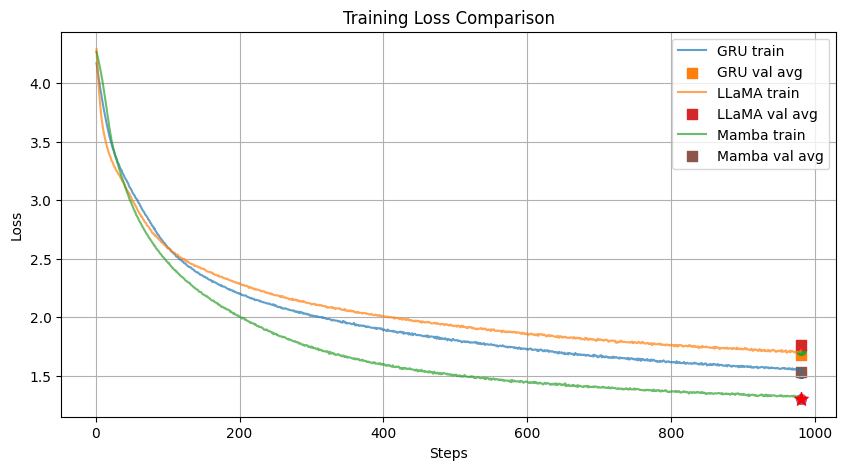

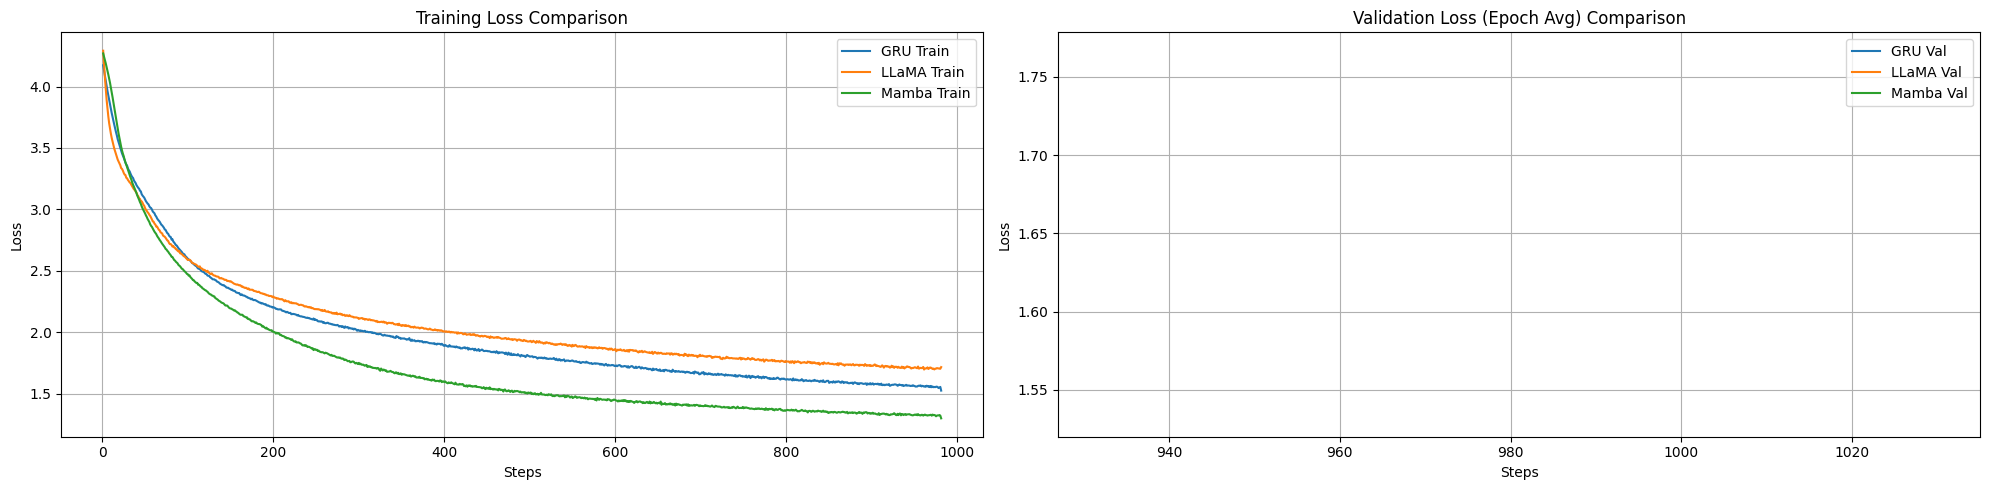

In [ ]:
train_and_test("Mamba", mamba, start_text)

## Model 4: minGRU

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from typing import List, Tuple, Optional, Union
from torch.nn import RMSNorm # 사용자의 환경에 RMSNorm이 torch.nn에 있다고 가정합니다.

class CausalDepthWiseConv1d(nn.Module):
    """
    인과적(Causal) 1D 깊이별 분리형 컨볼루션(Depth-wise Separable Convolution) 모듈.
    깊이별 컨볼루션과 점별 컨볼루션을 순차적으로 적용합니다.
    인과성을 유지하기 위해 시퀀스의 왼쪽에 패딩을 추가하여,
    시간 t의 출력은 시간 t까지의 입력에만 의존하도록 합니다.
    """
    def __init__(self, dimension: int, kernel_size: int):
        """
        Args:
            dimension (int): 입력 및 출력 채널의 수.
            kernel_size (int): 컨볼루션 커널의 크기.
        """
        super().__init__()
        self.kernel_size = kernel_size
        # 인과적 패딩 계산: (커널 크기 - 1) 만큼 왼쪽에, 0만큼 오른쪽에 패딩.
        self.causal_padding = (self.kernel_size - 1, 0)

        self.depthwise_pointwise_conv = nn.Sequential(
            # 깊이별 컨볼루션: 각 입력 채널에 대해 독립적인 필터를 적용.
            nn.Conv1d(dimension, dimension, kernel_size=kernel_size, groups=dimension),
            # 점별 컨볼루션: 채널 정보를 혼합하기 위한 1x1 컨볼루션.
            nn.Conv1d(dimension, dimension, kernel_size=1)
        )

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        """
        Args:
            x (torch.Tensor): 입력 텐서. 형태: (배치 크기, 시퀀스 길이, 채널 수).
        Returns:
            torch.Tensor: 출력 텐서. 형태: (배치 크기, 시퀀스 길이, 채널 수).
        """
        # Conv1D를 위해 (배치 크기, 채널 수, 시퀀스 길이) 형태로 변경.
        x_transposed = x.transpose(1, 2)
        # 시퀀스 왼쪽에 인과적 패딩 적용.
        x_padded = F.pad(x_transposed, self.causal_padding)
        # 깊이별-점별 컨볼루션 적용.
        x_conv_out = self.depthwise_pointwise_conv(x_padded)
        # 다시 (배치 크기, 시퀀스 길이, 채널 수) 형태로 변경.
        return x_conv_out.transpose(1, 2)


class MinGRUCoreOps:
    """
    MinGRU의 핵심 수학적 연산을 위한 정적 메소드들을 포함하는 클래스.
    MinGRU의 수학적 공식에 기반한 함수들이며, 사용자 정의 활성화 함수 및
    순환적 업데이트를 위한 병렬 스캔 연산 등을 포함합니다.
    원문에서는 mF 네임스페이스로 사용되었습니다.
    """

    @staticmethod
    def g_activation(x: torch.Tensor) -> torch.Tensor:
        """
        MinGRU를 위한 사용자 정의 활성화 함수 'g'.
        g(x) = x + 0.5  (x >= 0 인 경우)
        g(x) = sigmoid(x) (x < 0 인 경우)
        """
        output = torch.empty_like(x)
        positive_mask = x >= 0
        # 양수 또는 0인 경우
        output[positive_mask] = x[positive_mask] + torch.tensor(0.5, dtype=x.dtype, device=x.device)
        # 음수인 경우
        output[~positive_mask] = torch.sigmoid(x[~positive_mask])
        return output

    @staticmethod
    def log_g_activation(x: torch.Tensor) -> torch.Tensor:
        """
        사용자 정의 활성화 함수 'g'의 로그(logarithm) 값.
        log_g(x) = log(x + 0.5) (x >= 0 인 경우)
        log_g(x) = log(sigmoid(x)) = -softplus(-x) (x < 0 인 경우)
        수치적 안정성을 위해 사용됩니다.
        """
        output = torch.empty_like(x)
        positive_mask = x >= 0
        # 양수 또는 0인 경우
        output[positive_mask] = (x[positive_mask] + torch.tensor(0.5, dtype=x.dtype, device=x.device)).log().to(x.dtype)
        # 음수인 경우 (log(sigmoid(x)) = -softplus(-x))
        output[~positive_mask] = (-F.softplus(-x[~positive_mask])).to(x.dtype)
        return output

    @staticmethod
    def _log_space_parallel_scan(log_a_terms: torch.Tensor, log_b_terms: torch.Tensor) -> torch.Tensor:
        """
        로그 공간에서의 병렬 스캔(누적) 연산.
        MinGRU의 순환 관계를 병렬적으로 계산하기 위해 사용됩니다.
        x_t = a_t * x_{t-1} + b_t  형태의 연산을 로그 공간에서 수행합니다.
        (원문: _parallel_scan_log)

        Args:
            log_a_terms (torch.Tensor): 로그 스케일의 'a' 항들. (log(a_t))
            log_b_terms (torch.Tensor): 로그 스케일의 'b' 항들. (log(b_t))
                                      첫 번째 요소는 log(x_0) * a_0 (초기 상태 관련 항)을 포함할 수 있음.
        Returns:
            torch.Tensor: 병렬 스캔 결과의 지수 값 (원래 스케일). (exp(log_x_t))
        """
        # log_a_terms의 누적 합을 계산 (alpha_star). 시퀀스 차원(dim=1)을 따라 누적.
        # 패딩은 초기 조건(x_0)을 처리하기 위함.
        padding_dims = [0] * (log_a_terms.ndim - 2) * 2 + [1, 0] # (..., 1, 0) sequence dimension padding
        alpha_star = F.pad(torch.cumsum(log_a_terms, dim=1), padding_dims)

        # log_b_terms - alpha_star 항에 대해 로그-합-지수(logsumexp) 누적을 수행.
        # 이는 x_0 항과 b_t / (a_1*...*a_t) 항들의 누적 합을 로그 공간에서 계산하는 것과 유사.
        x0_plus_b_star_contribution = torch.logcumsumexp(log_b_terms - alpha_star, dim=1)

        # 최종 로그 스케일 결과: alpha_star + x0_plus_b_star_contribution
        log_x_sequence = alpha_star + x0_plus_b_star_contribution
        return torch.exp(log_x_sequence)

    @staticmethod
    def _mingru_recurrent_update_log_space(log_previous_hidden_state: torch.Tensor,
                                           gate_z: torch.Tensor,
                                           candidate_hidden: torch.Tensor) -> torch.Tensor:
        """
        MinGRU의 순환 업데이트를 로그 공간에서 병렬적으로 수행.
        h_t = (1-z_t)*h_{t-1} + z_t*h_tilde_t
        (원문: _mingru_parallel)

        Args:
            log_previous_hidden_state (torch.Tensor): 이전 은닉 상태의 로그 값 (log(h_{t-1})).
                                                     형태: (배치, 1, 은닉 차원) - 시퀀스의 첫 번째 요소에 해당.
            gate_z (torch.Tensor): 게이트 z_t 값. 형태: (배치, 시퀀스 길이, 은닉 차원).
            candidate_hidden (torch.Tensor): 후보 은닉 상태 h_tilde_t 값. 형태: (배치, 시퀀스 길이, 은닉 차원).

        Returns:
            torch.Tensor: 계산된 은닉 상태 시퀀스 h_t. 형태: (배치, 시퀀스 길이, 은닉 차원).
        """
        # log(z_t) = -softplus(-gate_z)  (log(sigmoid(gate_z)))
        log_z = -F.softplus(-gate_z)
        # log(1-z_t) = -softplus(gate_z) (log(sigmoid(-gate_z)))
        log_one_minus_z = -F.softplus(gate_z)

        # log(h_tilde_t) 계산
        log_candidate_hidden = MinGRUCoreOps.log_g_activation(candidate_hidden)

        # 병렬 스캔을 위한 log_b 항 구성:
        # 첫 번째 항은 log(h_prev) (실제로는 log(h_0) * (1-z_0)에 대응하는 항으로 변환됨)
        # 나머지 항은 log(z_t) + log(h_tilde_t)
        # log_previous_hidden_state는 (B, 1, H) 이므로, dim=1로 concat
        log_b_for_scan = torch.cat((log_previous_hidden_state, log_z + log_candidate_hidden), dim=1)

        # log_a 항은 log(1-z_t)
        # 병렬 스캔 실행
        # h_sequence_plus_initial 결과는 h_0, h_1, ..., h_T-1 을 포함
        h_sequence_plus_initial = MinGRUCoreOps._log_space_parallel_scan(log_one_minus_z, log_b_for_scan)

        # 초기 상태 h_0를 제외한 h_1, ..., h_T-1 시퀀스 반환
        return h_sequence_plus_initial[:, 1:]

    @staticmethod
    def calculate_output_sequence(gate_z: torch.Tensor,
                                  candidate_hidden: torch.Tensor,
                                  initial_hidden_state: torch.Tensor) -> torch.Tensor:
        """
        주어진 게이트, 후보 은닉 상태, 초기 은닉 상태를 사용하여 MinGRU의 출력 시퀀스를 계산.
        (원문: mingru_gate_hidden)

        Args:
            gate_z (torch.Tensor): 게이트 z_t 값.
            candidate_hidden (torch.Tensor): 후보 은닉 상태 h_tilde_t 값.
            initial_hidden_state (torch.Tensor): 초기 은닉 상태 h_0 값.

        Returns:
            torch.Tensor: 계산된 은닉 상태 시퀀스.
        """
        # 수치적 안정성을 위해 작은 epsilon 값을 더한 후 로그 변환.
        epsilon = torch.tensor(1e-12, dtype=initial_hidden_state.dtype, device=initial_hidden_state.device)
        log_initial_hidden_state = (initial_hidden_state + epsilon).log()

        return MinGRUCoreOps._mingru_recurrent_update_log_space(log_initial_hidden_state, gate_z, candidate_hidden)


class MinGRU(nn.Module):
    """
    MinGRU (Minimal Gated Recurrent Unit) 모델.
    여러 MinGRU 레이어를 쌓아 구성할 수 있습니다.
    """
    # 타입 힌트 (JIT 호환성을 위해 Final 제거)
    layer_dims: Tuple[int, ...]
    num_internal_layers: int

    def __init__(
        self,
        input_dim: int,
        hidden_dims_list: List[int],
        use_bias: bool = True,
        apply_layer_norm: bool = True,
        dropout_probability: float = 0.1,
        use_residual: bool = True,
    ):
        """
        Args:
            input_dim (int): 입력 특징의 차원.
            hidden_dims_list (List[int]): 각 MinGRU 레이어의 은닉 차원 리스트.
            use_bias (bool): 선형 계층에서 편향을 사용할지 여부.
            apply_layer_norm (bool): 각 레이어 내부에 LayerNorm을 적용할지 여부.
            dropout_probability (float): 드롭아웃 확률. 0이면 드롭아웃을 적용하지 않음.
            use_residual (bool): 잔차 연결(residual connection)을 사용할지 여부.
        """
        super().__init__()
        self.layer_dims = tuple([input_dim] + hidden_dims_list) # 입력 차원 + 각 레이어 은닉 차원
        self.num_internal_layers = len(hidden_dims_list) # MinGRU 레이어의 수
        self.dropout_probability = dropout_probability
        self.use_residual = use_residual
        self.apply_internal_norm = apply_layer_norm

        torch_layers_list = [] # nn.ModuleList로 관리될 레이어 모듈들
        # 각 레이어의 입력 차원과 출력 차원을 순회
        layer_dim_pairs = zip(self.layer_dims[:-1], self.layer_dims[1:])

        for layer_idx, (current_input_dim, current_output_dim) in enumerate(layer_dim_pairs):
            layer_modules_dict = {} # nn.ModuleDict로 관리될 특정 레이어의 모듈들

            if self.apply_internal_norm:
                layer_modules_dict["norm"] = torch.nn.LayerNorm(current_input_dim)
            else:
                layer_modules_dict["norm"] = torch.nn.Identity()

            # 게이트(z_t)와 후보 은닉 상태(h_tilde_t)를 계산하기 위한 선형 계층
            layer_modules_dict["gate_and_candidate_proj"] = torch.nn.Linear(current_input_dim, current_output_dim * 2, bias=use_bias)

            # 잔차 연결을 위한 차원 정렬용 선형 계층 (입력과 출력 차원이 다를 경우)
            if use_residual and current_input_dim != current_output_dim:
                layer_modules_dict["residual_align_proj"] = torch.nn.Linear(current_input_dim, current_output_dim, bias=False)
            else:
                layer_modules_dict["residual_align_proj"] = torch.nn.Identity()

            # 드롭아웃 (마지막 레이어 제외)
            if self.dropout_probability > 0.0 and layer_idx < (self.num_internal_layers - 1):
                layer_modules_dict["dropout"] = torch.nn.Dropout(p=self.dropout_probability)
            else:
                layer_modules_dict["dropout"] = torch.nn.Identity()

            torch_layers_list.append(torch.nn.ModuleDict(layer_modules_dict))

        self.layers = torch.nn.ModuleList(torch_layers_list)
        self.apply(self._init_weights)  # 가중치 초기화
        
    def _init_weights(self, module: nn.Module):
        # 선형 레이어 가중치 초기화 (게이트 편향 특수 처리 포함)
        for i in range(self.num_internal_layers):
            layer_components = self.layers[i]
            output_dim = self.layer_dims[i+1]
            # 1. 잔차 연결 프로젝션 레이어 초기화 (일반)
            if isinstance(layer_components["residual_align_proj"], nn.Linear):
                nn.init.normal_(layer_components["residual_align_proj"].weight, mean=0.0, std=0.02)
            
            # 2. 게이트 및 후보 은닉 상태 프로젝션 레이어 특별 초기화
            gate_hidden_proj_layer = layer_components["gate_and_candidate_proj"]
            
            # 가중치는 표준 정규분포로 초기화
            nn.init.normal_(gate_hidden_proj_layer.weight, mean=0.0, std=0.02)

            # 편향(bias)은 특별하게 초기화
            if gate_hidden_proj_layer.bias is not None:
                # 편향 텐서는 (output_dim * 2) 크기
                # 앞 절반은 게이트 로짓(gate_logits)용, 뒤 절반은 후보 은닉 상태(candidate_hidden_inputs)용
                
                # 게이트 로짓의 편향을 음수 값으로 초기화 (예: -1.0)
                # sigmoid(음수)는 0에 가까워져, z_t가 작아짐
                # h_t = (1-z_t)*h_{t-1} + z_t*h_tilde_t 에서 (1-z_t)가 커지므로
                # 학습 초기에 이전 은닉 상태 h_{t-1}를 더 많이 유지하도록 유도하여 안정적인 학습에 도움을 줍니다.
                nn.init.constant_(gate_hidden_proj_layer.bias[:output_dim], -1.0)
                
                # 후보 은닉 상태의 편향은 0으로 초기화
                nn.init.zeros_(gate_hidden_proj_layer.bias[output_dim:])
            

    def init_hidden_states(self, input_tensor: torch.Tensor) -> List[torch.Tensor]:
        """
        각 MinGRU 레이어의 초기 은닉 상태를 생성합니다.
        MinGRU의 g 활성화 함수를 사용하여 0으로 초기화된 텐서를 변환합니다.

        Args:
            input_tensor (torch.Tensor): 입력 텐서. 배치 크기, 자료형, 장치 정보를 얻기 위해 사용.
                                         형태: (배치 크기, 시퀀스 길이, 입력 차원).
        Returns:
            List[torch.Tensor]: 각 레이어의 초기 은닉 상태 리스트.
                                각 텐서의 형태: (배치 크기, 1, 해당 레이어의 은닉 차원).
        """
        batch_size = input_tensor.shape[0]
        initial_states = []
        for hidden_dim in self.layer_dims[1:]: # 각 레이어의 출력(은닉) 차원에 대해
            # (배치 크기, 1, 은닉 차원) 형태의 0 텐서 생성 후 g_activation 적용
            zeros = input_tensor.new_zeros(batch_size, 1, hidden_dim, dtype=input_tensor.dtype)
            initial_states.append(MinGRUCoreOps.g_activation(zeros))
        return initial_states

    def forward(
        self,
        input_sequence: torch.Tensor,
        initial_hidden_states_list: Optional[List[torch.Tensor]] = None,
    ) -> Tuple[torch.Tensor, List[torch.Tensor]]:
        """
        MinGRU 모델의 순방향 전파를 수행합니다.

        Args:
            input_sequence (torch.Tensor): 입력 시퀀스. 형태: (배치 크기, 시퀀스 길이, 입력 차원).
            initial_hidden_states_list (Optional[List[torch.Tensor]]):
                제공될 경우 사용할 초기 은닉 상태 리스트.
                None이면 내부적으로 init_hidden_states를 호출하여 생성.

        Returns:
            Tuple[torch.Tensor, List[torch.Tensor]]:
                - 최종 레이어의 출력 시퀀스. 형태: (배치 크기, 시퀀스 길이, 마지막 레이어의 은닉 차원).
                - 각 레이어의 다음 시퀀스를 위한 마지막 은닉 상태 리스트.
                  각 텐서의 형태: (배치 크기, 1, 해당 레이어의 은닉 차원).
        """
        if initial_hidden_states_list is None:
            hidden_states_for_layers = self.init_hidden_states(input_sequence)
        else:
            hidden_states_for_layers = initial_hidden_states_list

        current_layer_input_sequence = input_sequence
        next_step_hidden_states_list: List[torch.Tensor] = []

        for layer_idx in range(self.num_internal_layers):
            layer_module_components = self.layers[layer_idx]

            normalized_sequence = layer_module_components["norm"](current_layer_input_sequence)
            # 게이트와 후보 은닉 상태를 한 번에 계산 후 분리
            gate_values, candidate_hidden_states = layer_module_components["gate_and_candidate_proj"](normalized_sequence).chunk(2, dim=2)

            # 현재 레이어의 초기(또는 이전 스텝의) 은닉 상태
            previous_hidden_state_for_this_layer: torch.Tensor = hidden_states_for_layers[layer_idx]

            # MinGRU 순환 연산
            output_sequence_current_layer = MinGRUCoreOps.calculate_output_sequence(
                gate_values, candidate_hidden_states, previous_hidden_state_for_this_layer
            )
            # 다음 스텝(또는 다음 시퀀스)을 위한 마지막 은닉 상태 저장
            next_step_hidden_states_list.append(output_sequence_current_layer[:, -1:])

            if self.use_residual:
                residual_input = layer_module_components["residual_align_proj"](current_layer_input_sequence)
                output_sequence_current_layer = output_sequence_current_layer + residual_input

            current_layer_input_sequence = layer_module_components["dropout"](output_sequence_current_layer)

        return current_layer_input_sequence, next_step_hidden_states_list


class SwiGLUFFN(nn.Module):
    """
    SwiGLU 활성화 함수를 사용하는 FFN (FeedForward Network) 모듈.
    일반적으로 트랜스포머 모델에서 사용됩니다.
    """
    def __init__(self, dimension: int, expansion_factor: float = 2.0, dropout: float = 0.1):
        """
        Args:
            dimension (int): 입력 및 출력 차원.
            expansion_factor (float): 내부 은닉 차원을 결정하기 위한 확장 비율.
                                      실제 은닉 차원은 dimension * expansion_factor * (2/3) 근사.
            dropout (float): 드롭아웃 확률.
        """
        super().__init__()
        # 내부 은닉 차원 계산 (일반적으로 2/3는 GLU 계열에서 사용됨)
        # 또한, 보통 하드웨어 가속을 위해 8의 배수로 맞춤.
        hidden_dimension = int(dimension * expansion_factor * (2/3))
        hidden_dimension = (hidden_dimension + 7) // 8 * 8 # 8의 배수로 올림

        self.gate_proj = nn.Linear(dimension, hidden_dimension, bias=False) # W_gate
        self.up_proj = nn.Linear(dimension, hidden_dimension, bias=False)   # W_up
        self.down_proj = nn.Linear(hidden_dimension, dimension, bias=False) # W_down
        self.dropout_layer = nn.Dropout(dropout)
        self.activation_fn = nn.SiLU() # Swish 또는 Sigmoid Linear Unit

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        """
        SwiGLU FFN의 순방향 전파.
        Output = Dropout(W_down(SiLU(W_gate(x)) * W_up(x)))
        """
        gated_x = self.activation_fn(self.gate_proj(x))
        activated_x = gated_x * self.up_proj(x)
        return self.dropout_layer(self.down_proj(activated_x))

class minGRULM(nn.Module):
    """
    MinGRU를 핵심 순환 블록으로 사용하는 전체 언어 모델 아키텍처 (버전 3).
    임베딩, 선택적 컨볼루션, MinGRU 스택, FFN, 최종 정규화 및 출력 프로젝션을 포함합니다.
    """
    def __init__(
        self,
        vocab_size: int,
        embedding_dim: int,
        mingru_hidden_dims_config: Union[int, List[int]], # MinGRU 레이어들의 은닉 차원 설정
        num_mingru_layers: Optional[int] = None, # hidden_dims_config가 int일 경우 레이어 수
        dropout_rate: float = 0.1,
        rms_norm_epsilon: float = 1e-8,
        use_convolution_block: bool = True,
        conv_kernel_size: int = 3,
        ffn_expansion_factor: float = 1.0 # SwiGLUFFN의 확장 비율
    ):
        super().__init__()

        # MinGRU 내부 레이어들의 은닉 차원 리스트 결정
        if isinstance(mingru_hidden_dims_config, int):
            if num_mingru_layers is None or num_mingru_layers < 1:
                raise ValueError("`num_mingru_layers`는 `mingru_hidden_dims_config`가 정수일 때 양의 정수여야 합니다.")
            actual_mingru_hidden_dims = [mingru_hidden_dims_config] * num_mingru_layers
        elif isinstance(mingru_hidden_dims_config, list):
            if not mingru_hidden_dims_config:
                raise ValueError("`mingru_hidden_dims_config` 리스트는 비어있을 수 없습니다.")
            actual_mingru_hidden_dims = mingru_hidden_dims_config
        else:
            raise TypeError("`mingru_hidden_dims_config`는 정수 또는 정수 리스트여야 합니다.")

        # MinGRU 모듈의 입력 및 출력 차원
        first_mingru_layer_dim = actual_mingru_hidden_dims[0]
        last_mingru_layer_dim = actual_mingru_hidden_dims[-1]

        self.token_embedding = nn.Embedding(vocab_size, embedding_dim)

        # 임베딩 차원을 첫 번째 MinGRU 레이어의 입력 차원으로 프로젝션
        if embedding_dim != first_mingru_layer_dim:
            self.embedding_to_mingru_projection = nn.Linear(embedding_dim, first_mingru_layer_dim)
        else:
            self.embedding_to_mingru_projection = nn.Identity()

        # 선택적 인과적 깊이별 컨볼루션 블록
        if use_convolution_block:
            self.causal_conv_block = CausalDepthWiseConv1d(first_mingru_layer_dim, conv_kernel_size)
        else:
            self.causal_conv_block = nn.Identity()

        # MinGRU 전 정규화
        self.norm_before_mingru = RMSNorm(first_mingru_layer_dim, eps=rms_norm_epsilon)

        self.mingru_stack = MinGRU(
            input_dim=first_mingru_layer_dim,
            hidden_dims_list=actual_mingru_hidden_dims,
            apply_layer_norm=True, # MinGRU 내부 LayerNorm 사용
            dropout_probability=dropout_rate,
            use_residual=True      # MinGRU 내부 잔차 연결 사용
        )

        # MinGRU 블록의 입력과 출력 차원이 다를 경우 잔차 연결을 위한 프로젝션
        if first_mingru_layer_dim != last_mingru_layer_dim:
            self.mingru_residual_projection = nn.Linear(first_mingru_layer_dim, last_mingru_layer_dim)
        else:
            self.mingru_residual_projection = nn.Identity()

        # MinGRU 후, FFN 전 정규화
        self.norm_after_mingru_before_ffn = RMSNorm(last_mingru_layer_dim, eps=rms_norm_epsilon)
        self.ffn_block = SwiGLUFFN(
            dimension=last_mingru_layer_dim,
            expansion_factor=ffn_expansion_factor,
            dropout=dropout_rate
        )

        # 최종 정규화 및 로짓 프로젝션
        self.final_output_norm = RMSNorm(last_mingru_layer_dim, eps=rms_norm_epsilon)
        self.to_logits_projection = nn.Linear(last_mingru_layer_dim, vocab_size)
        
        self.apply(self._init_weights)

    def _init_weights(self, module: nn.Module): # module 인자를 명시적으로 타입 힌트
        """
        모델 내 각 모듈의 가중치를 초기화합니다.
        self.apply() 메소드에 의해 호출됩니다.
        """
        if isinstance(module, nn.Linear):
            nn.init.normal_(module.weight, mean=0.0, std=0.02)
            if module.bias is not None:
                nn.init.zeros_(module.bias)
        elif isinstance(module, nn.Embedding):
            nn.init.normal_(module.weight, mean=0.0, std=0.02) 
        elif isinstance(module, nn.Conv1d):
            nn.init.kaiming_normal_(module.weight, mode='fan_in', nonlinearity='leaky_relu') # mode='fan_in'이 일반적
            if module.bias is not None:
                nn.init.zeros_(module.bias)
        elif isinstance(module, RMSNorm):
            if hasattr(module, 'weight') and module.weight is not None: # RMSNorm에 weight가 있을 경우
                nn.init.ones_(module.weight)
        elif isinstance(module, nn.LayerNorm): # MinGRU 내부의 LayerNorm 처리
            if hasattr(module, 'weight') and module.weight is not None:
                nn.init.ones_(module.weight)
            if hasattr(module, 'bias') and module.bias is not None:
                nn.init.zeros_(module.bias)

    def forward(self, input_ids: torch.Tensor) -> torch.Tensor: # 반환 타입에서 None 제거, 일반적으로 로짓만 반환
        """
        minGRULM 모델의 순방향 전파.

        Args:
            input_ids (torch.Tensor): 입력 토큰 ID 시퀀스. 형태: (배치 크기, 시퀀스 길이).

        Returns:
            torch.Tensor: 최종 로짓. 형태: (배치 크기, 시퀀스 길이, 어휘 크기).
        """
        # 1. 임베딩 및 초기 프로젝션
        current_hidden_repr = self.token_embedding(input_ids)
        current_hidden_repr = self.embedding_to_mingru_projection(current_hidden_repr)

        # 2. (선택적) 컨볼루션 블록 + 잔차 연결
        residual_conv_input = current_hidden_repr
        if not isinstance(self.causal_conv_block, nn.Identity):
            # 컨볼루션 블록이 Identity가 아닐 때만 연산 (즉, use_convolution_block=True 일 때)
            current_hidden_repr = residual_conv_input + self.causal_conv_block(residual_conv_input)
        # else: current_hidden_repr은 residual_conv_input과 동일하게 유지됨

        # 3. MinGRU 블록 + 잔차 연결
        residual_mingru_input = current_hidden_repr
        mingru_input_normalized = self.norm_before_mingru(residual_mingru_input)
        mingru_output_sequence, _ = self.mingru_stack(mingru_input_normalized) # 다음 은닉 상태는 사용 안함
        current_hidden_repr = self.mingru_residual_projection(residual_mingru_input) + mingru_output_sequence

        # 4. FFN 블록 + 잔차 연결
        residual_ffn_input = current_hidden_repr
        ffn_input_normalized = self.norm_after_mingru_before_ffn(residual_ffn_input)
        current_hidden_repr = residual_ffn_input + self.ffn_block(ffn_input_normalized)

        # 5. 최종 정규화 및 로짓 계산
        final_representation_normalized = self.final_output_norm(current_hidden_repr)
        logits = self.to_logits_projection(final_representation_normalized)

        return logits, _

In [ ]:
### Model Initialization
mingru = minGRULM(vocab_size, EMBEDDING_DIM, int(HIDDEN_DIM*1.25), NUM_LAYERS).to(device)

In [ ]:
from torchinfo import summary

summary(mingru, input_size=(BATCH_SIZE, SEQUENCE_LENGTH), dtypes=[torch.long])

Layer (type:depth-idx)                   Output Shape              Param #
minGRULM                                 [1024, 256, 65]           --
├─Embedding: 1-1                         [1024, 256, 256]          16,640
├─Linear: 1-2                            [1024, 256, 320]          82,240
├─CausalDepthWiseConv1d: 1-3             [1024, 256, 320]          --
│    └─Sequential: 2-1                   [1024, 320, 256]          --
│    │    └─Conv1d: 3-1                  [1024, 320, 256]          1,280
│    │    └─Conv1d: 3-2                  [1024, 320, 256]          102,720
├─RMSNorm: 1-4                           [1024, 256, 320]          320
├─MinGRU: 1-5                            [1024, 256, 320]          --
│    └─ModuleList: 2-2                   --                        --
│    │    └─ModuleDict: 3-3              --                        206,080
│    │    └─ModuleDict: 3-4              --                        206,080
├─Identity: 1-6                          [1024, 256, 320] 

In [ ]:
train_and_test("minGRU", mingru, start_text)

KeyboardInterrupt: 